# Compare 2 methods for computing energy spectrum

## <font color='blue'> Plans

<font color='blue'>
- ...
    
</font>

## Table of contents
1. Two methods
    - FFTreal
    - velFT: Yi's method
    - How are they related?
2. Real data test
    - Generate perfect velocity correlation
    - Generate energy spectrum data using 2 methods at different concentrations
        - FFTreal
        - velFT
    - Compare 2 methods
3. Verify the calculation by comparing $E(x, y)$ with $\int E(k) dk$
    - load data
    - $\int E(k) dk$
        - FFTreal
        - velFT
    - Calculate kinetic energy directly from PIV
4. Conclusion
    - <font color='green'>Two methods agree with each other in total kinetic energy
    - <font color='green'>Compare with the benchmark -- the sum of squared velocity -- both methods show small discrepancies, ranging from factor of 2 to 3
    - <font color='red'> The curve shape obtained from the two methods are still very different, see Sec 2.3 for a flavor.

## 0 Packages and presettings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import typesetting.main as tm
from corr_utils import *
import os
from corrLib import *
from myImageLib import dirrec

In [2]:
data_master_dir = r'E:\Google Drive'
tm.prl()

## 1 Two methods

### 1.1 FFTreal: real part of standard fft

Energy spectrum function $E(k)$ is defined as
$$
E(k) = \oint \frac{1}{2} \Phi_{ii}(k)d S(k)
$$

where $\Phi_{ii}(k)$ is the diagonal term of velocity spectrum tensor, defined as

$$
\Phi_{ij}(k) = \iiint\limits_{-\infty}^{\infty} R_{ij}(r)e^{-ik\cdot r} dr
$$

here $r$ is position vector (x, y, z) and $R_{ij}$ is spatial velocity correlation of $u_i$, $u_j$ and $u_k$.

It is not feasible to measure the full 3 dimensional flow simultaneous, so take a step back and measure $R_{11}(x, y)$, and thus $\Phi_{11}(k_x, k_y)$.

One dimensional spectra $E_{ij}(k_1)$ are defined to be twice the one dimensional Fourier transform of $R_{ij}(e_1r_1)$:
$$
E_{ij}(k_1) \equiv \frac{1}{\pi}\int^\infty_{-\infty} R_{ij}(e_1r_1)e^{-ik_1r_1}d r_1
$$

Since the flow in the textbook is measured by hot wire, which is naturally 1D, whereas PIV is naturally 2D, I adapt the equation above to a 2D velocity correlation function version:
$$
E_{11}(k_x, k_y) \equiv \frac{1}{\pi}\int^\infty_{-\infty} R_{11}(x, y)e^{-ik\cdot r}d^2r
$$

### 1.2 velFT: Yi's method

$$
E(k_x, k_y) = \langle u_k(k_x, k_y)u^*_k(k_x, k_y)+v_k(k_x, k_y)v_k^*(k_x, k_y)\rangle/2
$$

The angle bracket $\langle\rangle$ denotes an average over consecutive frames.

### 1.3 How they are related?

<img src='temp_data\energy_spectrum_derivation_1.jpg' width='600px'>
<img src='temp_data\energy_spectrum_derivation_2.jpg' width='600px'>

The idea is to derive the energy spectrum definition in Yi's formula to the velocity correlation definition.
$$
E(k_x, k_y) = u_k(k_x, k_y)u_k^*(k_x, k_y)\\
= \iint u(x, y)e^{-ik_xx}e^{-k_yy}dxdy\left[\iint u(x', y')e^{-ik_xx'}e^{-ik_yy'}dx'dy'\right]^*\\
= \iint u(x, y)e^{-ik_xx}e^{-k_yy}dxdy\iint u^*(x', y')e^{ik_xx'}e^{ik_yy'}dx'dy'\\
= \iiiint u(x, y)u(x', y')e^{-ik_x(x-x')}e^{-k_y(y-y')}dxdydx'dy'\\
$$

here, we change variable and let $x'' = x - x'$ and $y'' = y - y'$ the original expression can be rearranged into
$$
\iiiint u(x'+x'', y'+y'')u(x', y')e^{-ik_xx''}e^{-k_yy''}d(x'+x'')d(y'+y'')dx'dy'\\
= \iint \left[\iint u(x'+x'', y'+y'')u(x', y')dx'dy'\right] e^{-ik_xx''}e^{-k_yy''} d(x'+x'')d(y'+y'')
$$

using the definition of velocity correlation function (average all possible pairs over available space):
$$
\langle u(x, y)u(x+x'', y+y'') \rangle = \frac{\iint u(x'+x'', y'+y'')u(x', y')dx'dy'}{\iint dx'dy'}
$$
we obtain
$$
\iint dx'dy'\iint \langle u(x, y)u(x+x'', y+y'') \rangle e^{-ik_xx''}e^{-k_yy''} dx''dy''\\
$$

the first integration is the available space size of velocity field, in this case the size of field of view $A$. In the code, $A$ should be step size $s$ times the row number $r$ and column number $c$ of velocity matrix size:
$$
A = rcss
$$
Note that $r$ and $s$ should have no unit and $s$ should have unit um. 

Let's draw a comparison between the two methods. Method I:
$$
E_1(k_x, k_y) = \iint \langle u(x, y)u(x+x'', y+y'') \rangle e^{-ik_xx''}e^{-k_yy''} dx''dy''
$$
Method II:
$$
E_2(k_x, k_y) = \iint dx'dy' \iint \langle u(x, y)u(x+x'', y+y'') \rangle e^{-ik_xx''}e^{-k_yy''} dx''dy''\\
= A  \iint \langle u(x, y)u(x+x'', y+y'') \rangle e^{-ik_xx''}e^{-k_yy''} dx''dy''
$$

Thus
$$
E_1(k_x, k_y) = \frac{E_2(k_x, k_y)}{A}
$$

We show that the two methods are equivalent mathematically. Next, we test this equivalence using experimental data.

### 2 Real data test

### 2.1 Generate perfect velocity correlation

The velocity correlation function should contain the minimum possible amount of noise, so that we can assume the noise from real space is negligible, and only consider the difference in FFT methods. Here, we use data from 08032020 (number 10, 7, 1, corresponding to volume fractions 1.6%, 3.2% and 6.4%, assuming single bacterium volume is 1 um$^3$). Each data is averaged over frame 3000-3400 to minimize the influence of random noise.

In [13]:
numList = [10, 7, 1]
labelList = [r'1.6%', r'3.2%', r'6.4%']
vcorr_2d = {}
for num, label in zip(numList, labelList):
    temp = []
    for n in range(3000, 3400, 2):
        pivDir = r'E:\moreData\08032020\piv_imseq\{0:02d}\{1:04d}-{2:04d}.csv'.format(num, n, n+1)
        X, Y, U, V = read_piv(pivDir)
        U *= 0.33
        V *= 0.33
        CV = spatial_correlation(U, U) + spatial_correlation(V, V) # 2D correlation
        temp.append(CV)
    vcorr_2d[label] = np.stack(temp, axis=0).mean(axis=0)  

In [14]:
# Save
folder = os.path.join(data_master_dir, r'Research projects\DF\data\technical-details\energy-spectrum-calculation')
for kw in vcorr_2d:
    np.save(os.path.join(folder, 'FFTreal-{}.npy'.format(kw)), vcorr_2d[kw])

In [20]:
# To load vcorr_2d from data
folder = os.path.join(data_master_dir, r'Research projects\DF\data\technical-details\energy-spectrum-calculation')
l = dirrec(folder, 'FFTreal-*')
vcorr_2d = {}
for d in l:
    kw = os.path.split(d)[1].replace('.npy', '')
    vcorr_2d[kw] = np.load(d)

In [21]:
vcorr_2d

{'FFTreal-1.6%': array([[ 0.7825251 ,  0.5742321 ,  0.36576036, ..., -0.02469306,
         -0.00411643,  0.00572426],
        [ 0.58522075,  0.47594513,  0.33914036, ..., -0.01855809,
          0.00247747,  0.01240824],
        [ 0.38660735,  0.35075019,  0.29243876, ..., -0.01335496,
          0.00511053,  0.00915753],
        ...,
        [ 0.02576882,  0.02854925,  0.02900482, ...,  0.00985461,
          0.01275749,  0.00414169],
        [ 0.02940554,  0.03021939,  0.02815774, ..., -0.01504967,
          0.00287266, -0.01863998],
        [ 0.02937579,  0.02854904,  0.02927931, ..., -0.09966113,
         -0.08884631, -0.06963468]]),
 'FFTreal-3.2%': array([[ 44.90452908,  41.48459722,  35.58358884, ...,  -8.53551704,
          -8.57582778,  -8.07219995],
        [ 41.27725862,  38.97021996,  34.02862087, ...,  -8.14450381,
          -7.98109413,  -7.3323213 ],
        [ 35.24685131,  33.88518671,  30.28457287, ...,  -7.23661478,
          -6.92940232,  -6.20248621],
        ...,
    

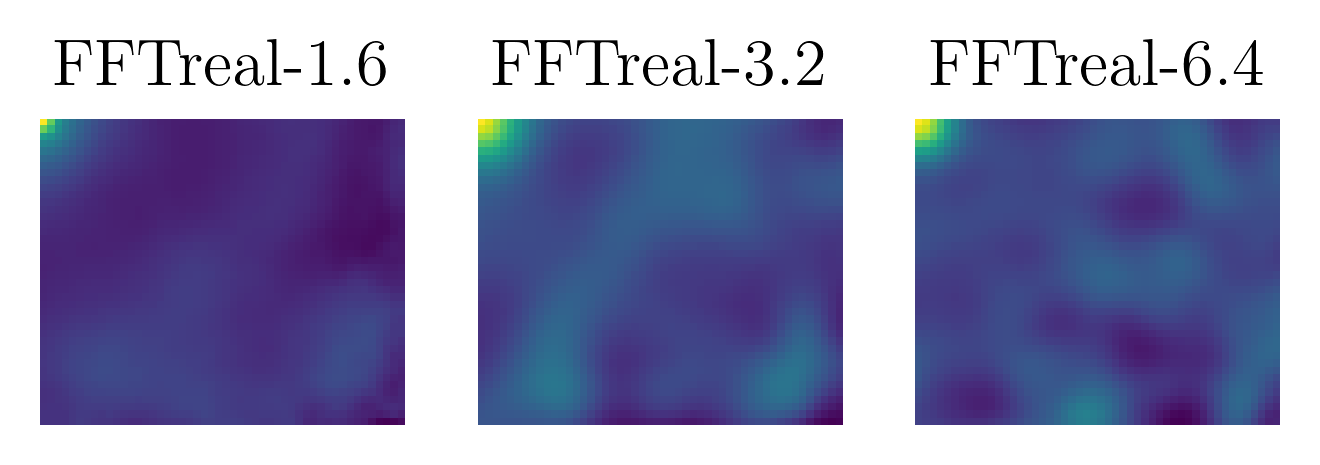

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(4, 1.3))
for num, kw in enumerate(vcorr_2d):
    ax[num].imshow(vcorr_2d[kw])
    ax[num].set_title(kw)
    ax[num].axis('off')

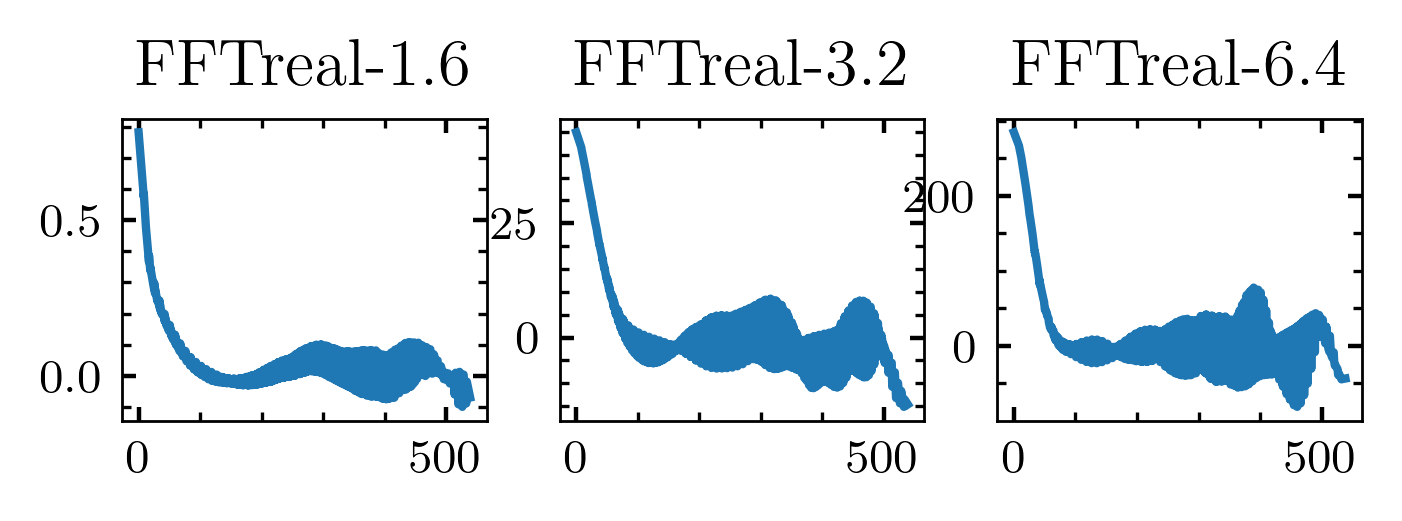

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(4, 1))
for num, kw in enumerate(vcorr_2d):
    corr = vcorr_2d[kw]
    x = np.linspace(0, corr.shape[1]*25*0.33, corr.shape[1])
    y = np.linspace(0, corr.shape[0]*25*0.33, corr.shape[0])
    X, Y = np.meshgrid(x, y)
    dc = distance_corr(X, Y, corr)
    ax[num].plot(dc.R, dc.C)
    ax[num].set_title(kw)

### 2.2 Compare energy spectra at different concentrations using two methods

#### 2.2.1 FFTreal

In [5]:
def energy_spectrum_FFTreal(CV, d=25*0.33):
    """
    Compute energy spectrum using method 2
    
    Args:
    CV -- spatial velocity correlation, a 2D numpy array
    d -- actual distance between adjacent velocity (PIV step)
    
    Returns:
    k -- wavenumber flattened
    E -- energy density flattened
    """
    
#     E = 1 / np.pi * np.fft.fft2(CV).real
    E = 1 / np.pi * np.fft.fft2(CV).real * d * d
    k, K = corrLib.compute_wavenumber_field(E.shape, d)

    ind = np.argsort(k.flatten())
    k_plot = k.flatten()[ind]
    E_plot = E.flatten()[ind]
    
    return k_plot, E_plot

In [25]:
kE_FFTreal = {} # save k, E data as dict of two-column np arrays (k, E)
for kw in vcorr_2d:
    k, E = energy_spectrum_FFTreal(vcorr_2d[kw], d=25*0.33)
    kE_FFTreal[kw] = np.stack([k, E], axis=1)

E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


Text(0.5, 1.0, 'FFTreal')

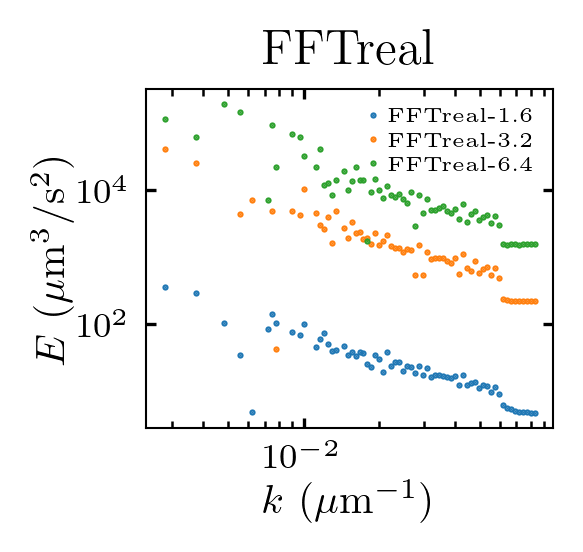

In [26]:
# plot
plt.figure(dpi=300)
for kw in kE_FFTreal:
    x, y = xy_bin(kE_FFTreal[kw][:, 0], kE_FFTreal[kw][:, 1])
    plt.plot(x, y, label=kw, ls='', marker='o', markersize=0.5)
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.loglog()
plt.title('FFTreal')

#### 2.2.2 velFT

In [3]:
numList = [10, 7, 1]
labelList = [r'velFT-1.6%', r'velFT-3.2%', r'velFT-6.4%']
kE_velFT = {} # dict of dataframe with two columns (k, E)
for num, label in zip(numList, labelList):
    for count, n in enumerate(range(3000, 3400, 2)):
        pivDir = r'E:\moreData\08032020\piv_imseq\{0:02d}\{1:04d}-{2:04d}.csv'.format(num, n, n+1)
        pivData = pd.read_csv(pivDir)
        if count == 0:
            es_temp = energy_spectrum(pivData, 25*0.33)
        else:
            es_temp += energy_spectrum(pivData, 25*0.33)
    kE_velFT[label] = (es_temp / (count + 1)).set_index('k') / 2

In [149]:
folder = os.path.join(data_master_dir, r'Research projects\DF\data\technical-details\energy-spectrum-calculation')
for kw in kE_velFT:
    kE_velFT[kw].to_csv(os.path.join(folder, '{}.csv'.format(kw)))

In [26]:
# load kE_velFT data
folder = os.path.join(data_master_dir, r'Research projects\DF\data\technical-details\energy-spectrum-calculation')
files = next(os.walk(folder))[2]
kE_velFT = {}
for f in files:
    if len(f.split('-')) == 2:
        kw = f.split('-')[0]
        kE_velFT[kw] = pd.read_csv(os.path.join(folder, f))

E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


Text(0.5, 1.0, 'velFT')

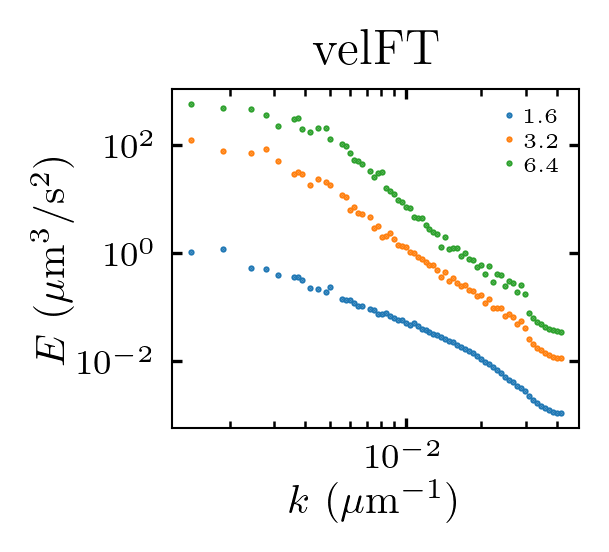

In [30]:
# plot kE_velFT
plt.figure(dpi=300)
for kw in kE_velFT:
    x, y = xy_bin(kE_velFT[kw]['k'], kE_velFT[kw]['E'])
    plt.plot(x, y, label=kw, ls='', marker='o', markersize=0.5)
plt.legend(fontsize=5)
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.loglog()

# slope guide eye
# s = -1.8
# x = np.array([0.015, 0.04])
# y = x ** s * 2e-3
# plt.plot(x, y, ls='--', lw=0.3, color='black')
# plt.text(x[0], y[1], '{:.1f}'.format(s), {'fontsize': 4})

# s = -4
# x = np.array([0.015, 0.04])
# y = x ** s * 1e-3
# plt.plot(x, y, ls='--', lw=0.3, color='black')
# plt.text(x[0], y[0], '{:.1f}'.format(s), {'fontsize': 4})

plt.title('velFT')

### 2.3 Compare the two methods at a fixed concentration

Clearly, the two methods presented above give different energy spectrum result. Below, I apply both methods on each concentration: 1.6%, 3.2% and 6.4%, and compare results.

In [6]:
folder = os.path.join(data_master_dir, r'Research projects\DF\data\technical-details\energy-spectrum-calculation')
files = next(os.walk(folder))[2]
kE_FFTreal = {}
kE_velFT = {}
vcorr_2d = {}
for f in files:
    if f != 'readme.txt':
        if f.split('-')[0] == 'velFT':
            kw = f.replace('.csv', '')
            kE_velFT[kw] = pd.read_csv(os.path.join(folder, f))
        elif f.split('-')[0] == 'FFTreal':
            kw = f.replace('.npy', '')
            vcorr_2d[kw] = np.load(os.path.join(folder, f))
            k, E = energy_spectrum_FFTreal(vcorr_2d[kw], d=25*0.33)
            kE_FFTreal[kw] = np.stack([k, E], axis=1)

E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])
E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


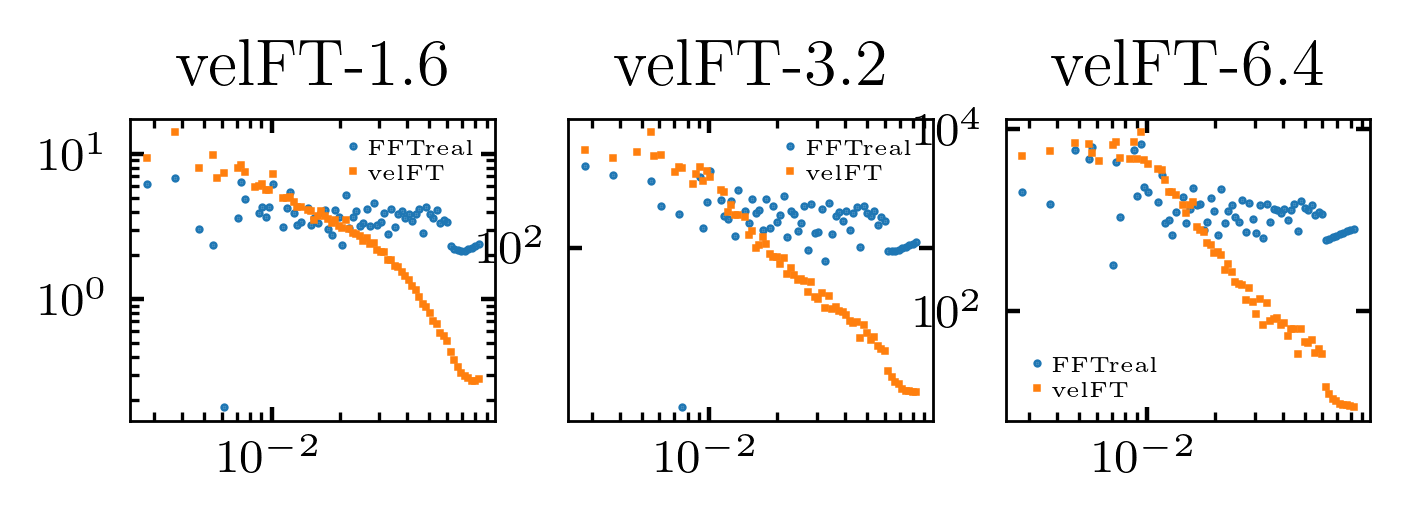

In [8]:
fig, ax = plt.subplots(figsize=(4, 1), nrows=1, ncols=3)
count = 0
for kw_FFTreal, kw_velFT in zip(kE_FFTreal, kE_velFT):
    x, y = xy_bin(kE_FFTreal[kw_FFTreal][:, 0], kE_FFTreal[kw_FFTreal][:, 1])
    y *= 2*np.pi*x
    ax[count].plot(x, y, label='FFTreal', ls='', marker='o', markersize=0.5, color=bestcolor(0))
    x, y = xy_bin(kE_velFT[kw_velFT].k, kE_velFT[kw_velFT].E)
    y *= 2*np.pi*x
    ax[count].plot(x, y, label='velFT', ls='', marker='s', markersize=0.5, color=bestcolor(1))
    ax[count].loglog()
    ax[count].legend(fontsize=4)
    ax[count].set_title('{}'.format(kw_velFT))
    count += 1

**Energy spectra calculation need further modifications**

In [146]:
def compute_energy_density(pivData, d=25*0.33):
    """
    Compute kinetic energy density in k space from piv data. The unit of the return value is [velocity] * [length],
    where [velocity] is the unit of pivData, and [length] is the unit of sample_spacing parameter.
    Note, the default value of sampling_spacing does not have any significance. It is just the most convenient value for my first application,
    and should be set with caution when a different magnification and PIV are used. 
    
    Args:
    pivData -- piv data
    d -- sample spacing
    
    Returns:
    E -- kinetic energy field in k space
    
    Test:
    pivData = pd.read_csv(r'E:\moreData\08032020\piv_imseq\01\3370-3371.csv')
    compute_energy_density(pivData)
    
    Edit:
    11020202 -- Add parameter sample_spacing, the distance between adjacent velocity (or data in general.
                The spacing is used to rescale the DFT so that it has a unit of [velocity] * [length].
                In numpy.fft, the standard fft function is defined as
                
                A_k = \sum\limits^{n-1}_{m=0} a_m \exp \left[ -2\pi i \frac{mk}{n} \right]
                
                The unit of this Fourier Transform $A_k$ is clearly the same as $a_m$. 
                In order to get unit [velocity] * [length], and to make transform result consistent at different data density,
                I introduce sample_spacing $d$ as a modifier of the DFT. After this modification, the energy spectrum computed
                at various step size (of PIV) should give quantitatively similar results.
    11042020 -- Replace the (* sample_spacing * sample_spacing) after v_fft with ( / row / col). This overwrites the edit I did on 11022020.
    11112020 -- removed ( / row / col), add the area constant in energy_spectrum() function. 
                Details can be found in https://zloverty.github.io/research/DF/blogs/energy_spectrum_2_methods_11112020.html               
    """
    
    row = len(pivData.y.drop_duplicates())
    col = len(pivData.x.drop_duplicates())
    U = np.array(pivData.u).reshape((row, col))
    V = np.array(pivData.v).reshape((row, col))
    
    u_fft = np.fft.fft2(U*0.33) * d * d
    v_fft = np.fft.fft2(V*0.33) * d * d
    
    E = (u_fft * u_fft.conjugate() + v_fft * v_fft.conjugate()) / 2
    
    return E

In [147]:
def energy_spectrum(pivData, d=25*0.33):
    """
    Compute energy spectrum (E vs k) from pivData.
    
    Args:
    pivData -- piv data
    d -- sample spacing. This is the distance between adjacent samples, for example, velocities in PIV. 
        The resulting frequency space has the unit which is inverse of the unit of d. The default unit of d is um.
    
    Returns:
    es -- energy spectrum, DataFrame (k, E)
    
    Edit:
    10192020 -- add argument d as sample spacing
    11112020 -- add area constant, see details in https://zloverty.github.io/research/DF/blogs/energy_spectrum_2_methods_11112020.html
    """
    
    row = len(pivData.y.drop_duplicates())
    col = len(pivData.x.drop_duplicates())
    
    E = compute_energy_density(pivData, d) / (row * d * col * d)
    k, K = compute_wavenumber_field(E.shape, d)
    
    ind = np.argsort(k.flatten())
    k_plot = k.flatten()[ind]
    E_plot = E.real.flatten()[ind]
    
    es = pd.DataFrame(data={'k': k_plot, 'E': E_plot})
    
    return es

## 3 Verify the calculation by comparing $E(x, y)$ with $\int E(k) dk$

**First load data by running the block below**

In [150]:
folder = os.path.join(data_master_dir, r'Research projects\DF\data\technical-details\energy-spectrum-calculation')
files = next(os.walk(folder))[2]
kE_FFTreal = {}
kE_velFT = {}
for f in files:
    if f != 'readme.txt':
        if f.split('-')[0] == 'velFT':
            kw = f.replace('.csv', '')
            kE_velFT[kw] = pd.read_csv(os.path.join(folder, f))
        elif f.split('-')[0] == 'FFTreal':
            kw = f.replace('.npy', '')
            vcorr_2d[kw] = np.load(os.path.join(folder, f))
            k, E = energy_spectrum_FFTreal(vcorr_2d[kw], d=25*0.33)
            kE_FFTreal[kw] = np.stack([k, E], axis=1)
kE_velFT

{'velFT-1.6%':              k            E
 0     0.000000  1106.815578
 1     0.002424   762.297370
 2     0.002424   762.297370
 3     0.002886   529.098521
 4     0.002886   529.098521
 ...        ...          ...
 2095  0.083694     0.523703
 2096  0.083694     0.523703
 2097  0.084013     0.565219
 2098  0.084013     0.565219
 2099  0.085710     0.519518
 
 [2100 rows x 2 columns],
 'velFT-3.2%':              k             E
 0     0.000000  41721.416631
 1     0.002424  42413.937505
 2     0.002424  42413.937505
 3     0.002886  62418.502188
 4     0.002886  62418.502188
 ...        ...           ...
 2095  0.083694      5.521963
 2096  0.083694      5.521963
 2097  0.084013      5.720127
 2098  0.084013      5.720127
 2099  0.085710      5.250012
 
 [2100 rows x 2 columns],
 'velFT-6.4%':              k              E
 0     0.000000  161406.203298
 1     0.002424  192318.013218
 2     0.002424  192318.013218
 3     0.002886  286211.920929
 4     0.002886  286211.920929
 ...    

### 3.1 $\int E(k) dk$

#### 3.1.1 FFTreal

In [36]:
for num, kw in enumerate(kE_FFTreal):
    x, y = xy_bin(kE_FFTreal[kw][:, 0], kE_FFTreal[kw][:, 1])
    y *= 2*np.pi*x
    clean_data = pd.DataFrame({'x': x, 'y': y}).dropna(axis=0)
    intE = np.trapz(clean_data.y, clean_data.x)
    print('{0} | {1:f}'.format(kw, intE))

FFTreal-1.6% | 0.261758
FFTreal-3.2% | 14.636767
FFTreal-6.4% | 92.240850


E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


#### 3.1.2 velFT

In [151]:
for num, kw in enumerate(kE_velFT):
    x, y = xy_bin(kE_velFT[kw].k, kE_velFT[kw].E)
    y *= 2*np.pi*x
    clean_data = pd.DataFrame({'x': x, 'y': y}).dropna(axis=0)
    intE = np.trapz(clean_data.y, clean_data.x)
    print('{0} | {1:f}'.format(kw, intE))

velFT-1.6% | 0.172536
velFT-3.2% | 9.460935
velFT-6.4% | 63.474551


E:\Github\Python\Correlation\src\corr_utils.py:1265: RuntimeWarning: invalid value encountered in true_divide
  np.histogram(xo, x)[0])


### 3.2 Calculate kinetic energy directly from PIV

In [137]:
folder = os.path.join(data_master_dir, r'Research projects\DF\data\technical-details\energy-spectrum-calculation')
l = dirrec(folder, 'PIV-*')
for kw, d in zip(kE_velFT, l):
    pivData = pd.read_csv(d)
    E = (pivData.u ** 2 + pivData.v ** 2).mean() * 0.33 ** 2 / 2
    print('{0} | {1:f}'.format(kw, E))

velFT-1.6% | 0.343480
velFT-3.2% | 26.593591
velFT-6.4% | 175.159691


## <font color='green'> Conlusion
    
<font color='green'>
    
1. Two methods agree with each other in total kinetic energy
2. Compare with the benchmark -- the sum of squared velocity -- both methods show small discrepancies, ranging from factor of 2 to 3   
3. <font color='red'> The curve shape obtained from the two methods are still very different, see Sec 2.3 for a flavor.